In [ ]:
import os
import time
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, TensorDataset
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from model import *
from utils import *
from train import *

torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load data

In [ ]:
dir_path = '/home/scar/Desktop/sanghoon/crois/data/splitted_100ms'

train_tnum = 'T1'
test_tnum = 'T5'

Tx_train = preprocess_data(train_tnum, dir_path)
Tx_test = preprocess_data(test_tnum, dir_path)

train_slice = Tx_train[Tx_train['Expt'].isin([1, 2])].drop(columns=['Expt']).to_numpy()  # Expt 1, 2만 사용

scaler = StandardScaler()
train_slice_scaled = scaler.fit_transform(train_slice)

# model train

In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

best_model, val_scores = train_model(train_slice_scaled, 100, 42, skf)

model_path = "model.pkl"
preprocessor_path = "preprocessor.pkl"
best_model.save(model_path, preprocessor_path)

In [ ]:
print(f'Cross Validation Scores: {val_scores}')
print(f'Average Validation Accuracy: {np.mean(val_scores):.4f}')

Cross Validation Scores: [0.9232870370370371, 0.9276388888888889, 0.9136574074074074, 0.9152314814814815, 0.9115740740740741]
Average Validation Accuracy: 0.9183


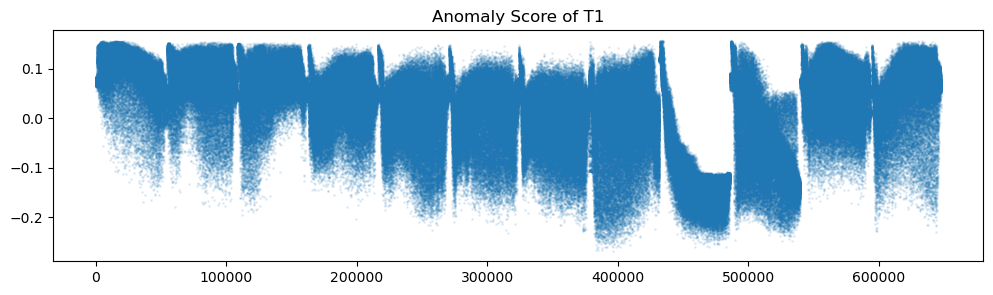

In [ ]:
# T1의 anomaly score
scores = best_model.model.decision_function(scaler.transform(Tx_train.drop(columns=['Expt']).to_numpy()))

plt.figure(figsize=(12, 3))
plt.scatter(range(len(scores)), scores, s=1, alpha=0.1)
plt.title(f'Anomaly Score of T1')
plt.show()

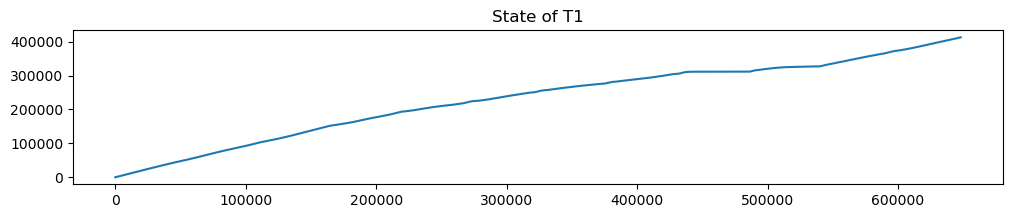

In [ ]:
# Anomaly score -> Health index (state)
state_t1 = train.health_index(scores, th=0, increase_step=1, decrease_step=0.001)

plt.figure(figsize=(12, 2))
plt.plot(state_t1)
plt.title(f'State of T1')
plt.show()